# Pipeline-CodeBERT

This python will introduce CodeBERT<sup>1</sup> Model, published by Microsoft.

CodeBERT is a bimodal pre-trained model for programming language and natural language. It is based on Transformer neural architecture. Total number of model parameter is 125M. 

### Input/Output Representations
In the pre-training phase, input is set as concatenation of two segments with a special separator token **[CLS], w1, w2, .., wn, [SEP], c1, c2,.., cn[EOS]**. One segment is natural language text and another is code from programming language. **[CLS]** is a special token in front of these two segments, whose final hidden representation is considered as the aggregated sequence reproresentation for classification or ranking. The model uses **WordPiece** tokenizer.

Output of CodeBERT includes
1. contextual vector representation of each token for both natural language and code.
2. Representation of **[CLS]**, which works as aggregated sequence representation.

### Pre-Training Data 
CodeBERT was trained with bimodal data which refers to parallel data of natural langugae-code pairs and unimodal data which stands for codes without paired natural language texts and natural language without paired codes.

CodeBERT uses the methodology from Electra<sup>2</sup>, where bidirectional model like BERT will learn from both directions in all positions compared to BERT, which will learn only 15% masked words.

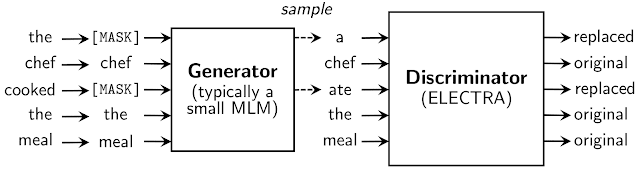


### Fine Tunining Data
CodeBERT feeds the input as the same as pre-training phase and use the representation of **[CLS]** to measure the semantic relevance between code and the natural language query. The paper trained the model with binary classification loss function, where a softmax layer is connected to the representation of **[CLS]**. 


In [3]:
from platform import python_version
print(python_version())

3.9.16


In [4]:
# run.py from CodeXGLUE
from __future__ import absolute_import, division, print_function

import argparse
import glob
import logging
import os
import pickle
import random
import re
import shutil

import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler,TensorDataset
from torch.utils.data.distributed import DistributedSampler
import json
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    from tensorboardX import SummaryWriter
from tqdm import tqdm, trange
import multiprocessing
cpu_cont = multiprocessing.cpu_count()
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          BertConfig, BertForMaskedLM, BertTokenizer,
                          GPT2Config, GPT2LMHeadModel, GPT2Tokenizer,
                          OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer,
                          RobertaConfig, RobertaModel, RobertaTokenizer,
                          DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer)
logger = logging.getLogger(__name__)

print(f"cpu count: {cpu_cont}")

cpu count: 32


In [5]:
MODEL_CLASSES = {
    'gpt2': (GPT2Config, GPT2LMHeadModel, GPT2Tokenizer),
    'openai-gpt': (OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer),
    'bert': (BertConfig, BertForMaskedLM, BertTokenizer),
    'roberta': (RobertaConfig, RobertaModel, RobertaTokenizer),
    'distilbert': (DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer)
}

In [6]:
import torch
import torch.nn as nn
import torch
from torch.autograd import Variable
import copy
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss


    
class Model(nn.Module):   
    def __init__(self, encoder,config,tokenizer,args):
        super(Model, self).__init__()
        self.encoder = encoder
        self.config=config
        self.tokenizer=tokenizer
        self.args=args
    
        
    def forward(self, code_inputs,nl_inputs,return_vec=False): 
        bs=code_inputs.shape[0]
        inputs=torch.cat((code_inputs,nl_inputs),0)
        outputs=self.encoder(inputs,attention_mask=inputs.ne(1))[1]
        code_vec=outputs[:bs]
        nl_vec=outputs[bs:]
        
        if return_vec:
            return code_vec,nl_vec
        scores=(nl_vec[:,None,:]*code_vec[None,:,:]).sum(-1)
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(scores, torch.arange(bs, device=scores.device))
        return loss,code_vec,nl_vec

In [7]:
#set seed helper
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYHTONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [8]:
#process the args
def process_args(args):
    args.n_gpu = torch.cuda.device_count()
    args.per_gpu_train_batch_size=args.train_batch_size//args.n_gpu
    args.per_gpu_eval_batch_size=args.eval_batch_size//args.n_gpu

    # Set seed
    set_seed(args.seed)
    
    return args
    

In [10]:
class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 code_tokens,
                 code_ids,
                 nl_tokens,
                 nl_ids,
                 url,
                 idx,

    ):
        self.code_tokens = code_tokens
        self.code_ids = code_ids
        self.nl_tokens = nl_tokens
        self.nl_ids = nl_ids
        self.url=url
        self.idx=idx

        
def convert_examples_to_features(js,tokenizer,args):
    #code
    if 'code_tokens' in js:
        code=' '.join(js['code_tokens'])
    else:
        code=' '.join(js['function_tokens'])
    code_tokens=tokenizer.tokenize(code)[:args.block_size-2]
    code_tokens =[tokenizer.cls_token]+code_tokens+[tokenizer.sep_token]
    code_ids =  tokenizer.convert_tokens_to_ids(code_tokens)
    padding_length = args.block_size - len(code_ids)
    code_ids+=[tokenizer.pad_token_id]*padding_length
    
    nl=' '.join(js['docstring_tokens'])
    nl_tokens=tokenizer.tokenize(nl)[:args.block_size-2]
    nl_tokens =[tokenizer.cls_token]+nl_tokens+[tokenizer.sep_token]
    nl_ids =  tokenizer.convert_tokens_to_ids(nl_tokens)
    padding_length = args.block_size - len(nl_ids)
    nl_ids+=[tokenizer.pad_token_id]*padding_length    
    
    return InputFeatures(code_tokens,code_ids,nl_tokens,nl_ids,js['url'],js['idx'])


In [12]:
class TextDataset(Dataset):
    def __init__(self, tokenizer, args, file_path=None):
        self.examples = []
        data=[]
        with open(file_path) as f:
            for line in f:
                line=line.strip()
                js=json.loads(line)
                data.append(js)
        for js in data:
            self.examples.append(convert_examples_to_features(js,tokenizer,args))
        if 'train' in file_path:
            for idx, example in enumerate(self.examples[:3]):
                    logger.info("*** Example ***")
                    logger.info("idx: {}".format(idx))
                    logger.info("code_tokens: {}".format([x.replace('\u0120','_') for x in example.code_tokens]))
                    logger.info("code_ids: {}".format(' '.join(map(str, example.code_ids))))
                    logger.info("nl_tokens: {}".format([x.replace('\u0120','_') for x in example.nl_tokens]))
                    logger.info("nl_ids: {}".format(' '.join(map(str, example.nl_ids))))                             
        
    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):   
        return (torch.tensor(self.examples[i].code_ids),torch.tensor(self.examples[i].nl_ids))

In [13]:
def train(args, train_dataset, model, tokenizer):
    """ Train the model """
    
    args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)
    train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, 
                                  batch_size=args.train_batch_size,num_workers=4,pin_memory=True)
    args.max_steps=args.epoch*len( train_dataloader)
    args.save_steps=len( train_dataloader)//10
    args.warmup_steps=len( train_dataloader)
    args.logging_steps=len( train_dataloader)
    args.num_train_epochs=args.epoch
    model.to(args.device)
    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': args.weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args.max_steps*0.1,
                                                num_training_steps=args.max_steps)
    if args.fp16:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

    # multi-gpu training (should be after apex fp16 initialization)
    if args.n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Distributed training (should be after apex fp16 initialization)
    if args.local_rank != -1:
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.local_rank],
                                                          output_device=args.local_rank,
                                                          find_unused_parameters=True)

    checkpoint_last = os.path.join(args.output_dir, 'checkpoint-last')
    scheduler_last = os.path.join(checkpoint_last, 'scheduler.pt')
    optimizer_last = os.path.join(checkpoint_last, 'optimizer.pt')
    if os.path.exists(scheduler_last):
        scheduler.load_state_dict(torch.load(scheduler_last))
    if os.path.exists(optimizer_last):
        optimizer.load_state_dict(torch.load(optimizer_last))
    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info("  Total train batch size (w. parallel, distributed & accumulation) = %d",
                args.train_batch_size * args.gradient_accumulation_steps * (
                    torch.distributed.get_world_size() if args.local_rank != -1 else 1))
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", args.max_steps)
    
    global_step = args.start_step
    tr_loss, logging_loss,avg_loss,tr_nb,tr_num,train_loss = 0.0, 0.0,0.0,0,0,0
    best_mrr=0.0
    best_acc=0.0
    # model.resize_token_embeddings(len(tokenizer))
    model.zero_grad()

 
    for idx in range(args.start_epoch, int(args.num_train_epochs)): 
        bar = train_dataloader
        tr_num=0
        train_loss=0
        for step, batch in enumerate(bar):
            code_inputs = batch[0].to(args.device)    
            nl_inputs = batch[1].to(args.device)

            model.train()
            loss,code_vec,nl_vec = model(code_inputs,nl_inputs)

            if args.n_gpu > 1:
                loss = loss.mean()  # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            if args.fp16:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

            tr_loss += loss.item()
            tr_num+=1
            train_loss+=loss.item()
            if avg_loss==0:
                avg_loss=tr_loss
            avg_loss=round(train_loss/tr_num,5)
            if (step+1)% 100==0:
                logger.info("epoch {} step {} loss {}".format(idx,step+1,avg_loss))
            #bar.set_description("epoch {} loss {}".format(idx,avg_loss))

                
            if (step + 1) % args.gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()  
                global_step += 1
                output_flag=True
                avg_loss=round(np.exp((tr_loss - logging_loss) /(global_step- tr_nb)),4)
                if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                    logging_loss = tr_loss
                    tr_nb=global_step

                if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
                    
                    if args.local_rank == -1 and args.evaluate_during_training:  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(args, model, tokenizer,eval_when_training=True)
                        for key, value in results.items():
                            logger.info("  %s = %s", key, round(value,4))                    
                        # Save model checkpoint
                        tr_num=0
                        train_loss=0
 
                    if results['eval_mrr']>best_acc:
                        best_acc=results['eval_mrr']
                        logger.info("  "+"*"*20)  
                        logger.info("  Best mrr:%s",round(best_acc,4))
                        logger.info("  "+"*"*20)                          
                        
                        checkpoint_prefix = 'checkpoint-best-mrr'
                        output_dir = os.path.join(args.output_dir, '{}'.format(checkpoint_prefix))                        
                        if not os.path.exists(output_dir):
                            os.makedirs(output_dir)                        
                        model_to_save = model.module if hasattr(model,'module') else model
                        output_dir = os.path.join(output_dir, '{}'.format('model.bin')) 
                        torch.save(model_to_save.state_dict(), output_dir)
                        logger.info("Saving model checkpoint to %s", output_dir)


In [36]:
eval_dataset=None
def evaluate(args, model, tokenizer,eval_when_training=False):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args.output_dir
    global eval_dataset
    if eval_dataset is None:
        eval_dataset = TextDataset(tokenizer, args,args.eval_data_file)

    if not os.path.exists(eval_output_dir) and args.local_rank in [-1, 0]:
        os.makedirs(eval_output_dir)

    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly
    eval_sampler = SequentialSampler(eval_dataset) if args.local_rank == -1 else DistributedSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size,num_workers=4,pin_memory=True)

    # multi-gpu evaluate
    if args.n_gpu > 1 and eval_when_training is False:
        model = torch.nn.DataParallel(model)

    # Eval!
    logger.info("***** Running evaluation *****")
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()
    code_vecs=[] 
    nl_vecs=[]
    for batch in eval_dataloader:
        code_inputs = batch[0].to(args.device)    
        nl_inputs = batch[1].to(args.device)
        with torch.no_grad():
            lm_loss,code_vec,nl_vec = model(code_inputs,nl_inputs)
            eval_loss += lm_loss.mean().item()
            code_vecs.append(code_vec.cpu().numpy())
            nl_vecs.append(nl_vec.cpu().numpy())
        nb_eval_steps += 1
    code_vecs=np.concatenate(code_vecs,0)
    nl_vecs=np.concatenate(nl_vecs,0)
    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.tensor(eval_loss)

    scores=np.matmul(nl_vecs,code_vecs.T)
    ranks=[]
    for i in range(len(scores)):
        score=scores[i,i]
        rank=1
        for j in range(len(scores)):
            if i!=j and scores[i,j]>=score:
                rank+=1
        ranks.append(1/rank)    
    
            
    result = {
        "eval_loss": float(perplexity),
        "eval_mrr":float(np.mean(ranks))
    }


    return result

In [ ]:
from types import SimpleNamespace

#Args
args = SimpleNamespace()

args.output_dir = "./saved_models"
args.model_type = "roberta"
args.config_name="microsoft/codebert-base"
args.model_name_or_path="microsoft/codebert-base"
args.tokenizer_name="roberta-base"
args.do_train=True
args.train_data_file="CodeXGLUE/dataset/train.jsonl"
args.eval_data_file="CodeXGLUE/dataset/valid.jsonl"
args.test_data_file="CodeXGLUE/dataset/test.jsonl"
args.epoch=2.0
args.block_size=256
args.train_batch_size=32
args.eval_batch_size=64
args.learning_rate=5e-5
args.max_grad_norm=1.0
args.evaluate_during_training=True
args.seed=123456

## optional args
args.no_cuda=False
args.local_rank=-1
args.fp16=False
args.cache_dir=""
args.do_lower_case=False
args.weight_decay=0.0
args.adam_epsilon=1e-8
args.max_steps=-1
args.gradient_accumulation_steps=1
args.logging_steps=50
args.save_steps=50
    
# Setup CUDA, GPU & distributed training
device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
args.device = device

args = process_args(args)

logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN)
logger.warning("Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
               args.local_rank, device, args.n_gpu, bool(args.local_rank != -1), args.fp16)
args.start_epoch = 0
args.start_step = 0
checkpoint_last = os.path.join(args.output_dir, 'checkpoint-last')
if os.path.exists(checkpoint_last) and os.listdir(checkpoint_last):
    args.model_name_or_path = os.path.join(checkpoint_last, 'pytorch_model.bin')
    args.config_name = os.path.join(checkpoint_last, 'config.json')
    idx_file = os.path.join(checkpoint_last, 'idx_file.txt')
    with open(idx_file, encoding='utf-8') as idxf:
        args.start_epoch = int(idxf.readlines()[0].strip()) + 1

    step_file = os.path.join(checkpoint_last, 'step_file.txt')
    if os.path.exists(step_file):
        with open(step_file, encoding='utf-8') as stepf:
            args.start_step = int(stepf.readlines()[0].strip())

    logger.info("reload model from {}, resume from {} epoch".format(checkpoint_last, args.start_epoch))

config_class, model_class, tokenizer_class = MODEL_CLASSES[args.model_type]
config = config_class.from_pretrained(args.config_name if args.config_name else args.model_name_or_path,
                                      cache_dir=args.cache_dir if args.cache_dir else None)
config.num_labels=1
tokenizer = tokenizer_class.from_pretrained(args.tokenizer_name,
                                            do_lower_case=args.do_lower_case,
                                            cache_dir=args.cache_dir if args.cache_dir else None)
if args.block_size <= 0:
    args.block_size = tokenizer.max_len_single_sentence  # Our input block size will be the max possible for the model
args.block_size = min(args.block_size, tokenizer.max_len_single_sentence)

if args.model_name_or_path:
    model = model_class.from_pretrained(args.model_name_or_path,
                                        from_tf=bool('.ckpt' in args.model_name_or_path),
                                        config=config,
                                        cache_dir=args.cache_dir if args.cache_dir else None)    
else:
    model = model_class(config)

model=Model(model,config,tokenizer,args)
if args.local_rank == 0:
    torch.distributed.barrier()  # End of barrier to make sure only the first process in distributed training download model & vocab

logger.info("Training/evaluation parameters %s", args)

# Training

if args.do_train:
    #if args.local_rank not in [-1, 0]:
    #    torch.distributed.barrier()  # Barrier to make sure only the first process in distributed training process the dataset, and the others will use the cache

    train_dataset = TextDataset(tokenizer, args,args.train_data_file)

    if args.local_rank == 0:
        torch.distributed.barrier()

    train(args, train_dataset, model, tokenizer)



# # Evaluation
# results = {}
# if args.do_eval and args.local_rank in [-1, 0]:
#     checkpoint_prefix = 'checkpoint-best-mrr/model.bin'
#     output_dir = os.path.join(args.output_dir, '{}'.format(checkpoint_prefix))  
#     model.load_state_dict(torch.load(output_dir))      
#     model.to(args.device)
#     result=evaluate(args, model, tokenizer)
#     logger.info("***** Eval results *****")
#     for key in sorted(result.keys()):
#         logger.info("  %s = %s", key, str(round(result[key],4)))

# if args.do_test and args.local_rank in [-1, 0]:
#     checkpoint_prefix = 'checkpoint-best-mrr/model.bin'
#     output_dir = os.path.join(args.output_dir, '{}'.format(checkpoint_prefix))  
#     model.load_state_dict(torch.load(output_dir))                  
#     model.to(args.device)
#     test(args, model, tokenizer)

# return results


In [26]:
!pwd

/localhome/local-dineshr/cs224n/cs224n-project/demos


### References
1. https://arxiv.org/pdf/2002.08155.pdf
2. https://ai.googleblog.com/2020/03/more-efficient-nlp-model-pre-training.html